# Fire and smoke detection AI Project
### Authors: Yana Muliarska, Nazar Dobrovolskyy

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix

In [2]:
BATCH_SIZE = 16
device = 'cpu'

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    ),
])

## Fire datasets processing

In [4]:
data = datasets.ImageFolder('data/dataset-merged/train_val',       
                    transform=train_transform)
train_data, val_data = torch.utils.data.random_split(data, [1455, 716])

In [5]:
label2name = ['fire', 'nonfire']

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=3
)

valid_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=3
)

## Smoke datasets processing

In [7]:
smoke_data = datasets.ImageFolder('data/smoke_data',       
                    transform=train_transform)

smoke_train_data, smoke_val_data = torch.utils.data.random_split(smoke_data, [4200, 2101])

In [8]:
smoke_label2name = ['nonsmoke', 'smoke']

In [9]:
smoke_train_dataloader = torch.utils.data.DataLoader(
    smoke_train_data, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=3
)

smoke_valid_dataloader = torch.utils.data.DataLoader(
    smoke_val_data, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=3
)

## Model initialization

In [10]:
class CNN_fire(nn.Module):
    def __init__(self, kernel_size=3,out_channels1=16, out_channels2=32, out_channels3=64 ):
        super(CNN_fire, self).__init__()
        
        self.features = nn.Sequential(
                        nn.Conv2d(3, 16 , (3, 3)),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.MaxPool2d(2),
                        nn.Conv2d(16, 32, (3, 3)),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2),
                        nn.Conv2d(32, 64, (3, 3)),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(
                          nn.Linear(13*13*64, 256),
                          nn.ReLU(),
                          nn.BatchNorm1d(256),
                          nn.Dropout(0.1),
                          nn.Linear(256,128),
                          nn.ReLU(),
                          nn.BatchNorm1d(128),
                          nn.Dropout(0.1),
                          nn.Linear(128, 2),
                          nn.BatchNorm1d(2))
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1, 13*13*64)
        x = self.classifier(x)
        x = self.sigmoid(x)
        
        return x

## Fire detection model training

In [11]:
model = CNN_fire()
model.to(device)

CNN_fire(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10816, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15

train_accs = []
train_losses = []

valid_accs = []
valid_losses = []
valid_labels = []
valid_preds =[]

for epoch in range(epochs):

    train_acc = 0
    train_loss = 0

    model.train()

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(output, 1)
        
        train_acc += (predictions == labels).sum().item()
        train_loss += loss.item()

    train_accs.append(train_acc / len(train_data))
    train_losses.append(train_loss / len(train_data))

    model.eval()

    valid_acc = 0
    valid_loss = 0

    with torch.no_grad():
        for images, labels in valid_dataloader:
            output = model(images)
            loss = loss_fn(output, labels)

            predictions = torch.argmax(output, 1)

            valid_acc += (predictions == labels).sum().item()
            valid_loss += loss.item()
            
            valid_labels.extend(labels)
            valid_preds.extend(predictions)

    valid_accs.append(valid_acc / len(val_data))
    valid_losses.append(valid_loss / len(val_data))

    print(f"Epoch {epoch + 1}")
    print(f"Training Accuracy: {round(train_acc / len(train_data), 3)} \
    Training Loss: {round(train_loss / len(train_data), 3)}")
    print(f"Validation Accuracy: {round(valid_acc / len(val_data), 3)} \
    Validation Loss: {round(valid_loss / len(val_data), 3)}\n")


Epoch 1
Training Accuracy: 0.891     Training Loss: 0.034
Validation Accuracy: 0.888     Validation Loss: 0.033

Epoch 2
Training Accuracy: 0.924     Training Loss: 0.032
Validation Accuracy: 0.94     Validation Loss: 0.031

Epoch 3
Training Accuracy: 0.935     Training Loss: 0.031
Validation Accuracy: 0.937     Validation Loss: 0.032

Epoch 4
Training Accuracy: 0.955     Training Loss: 0.03
Validation Accuracy: 0.927     Validation Loss: 0.03

Epoch 5
Training Accuracy: 0.953     Training Loss: 0.029
Validation Accuracy: 0.944     Validation Loss: 0.03

Epoch 6
Training Accuracy: 0.958     Training Loss: 0.029
Validation Accuracy: 0.943     Validation Loss: 0.03

Epoch 7
Training Accuracy: 0.966     Training Loss: 0.028
Validation Accuracy: 0.953     Validation Loss: 0.028

Epoch 8
Training Accuracy: 0.977     Training Loss: 0.027
Validation Accuracy: 0.941     Validation Loss: 0.029

Epoch 9
Training Accuracy: 0.984     Training Loss: 0.027
Validation Accuracy: 0.951     Validation L

## Metrics

In [13]:
print("Confusion matrix for fire detection:")
print(confusion_matrix(valid_labels, valid_preds))

# Confusion matrix of shape
# True Positive     False Positive
# False Negative    True Negative

Confusion matrix for fire detection:
[[3926  334]
 [ 338 6142]]


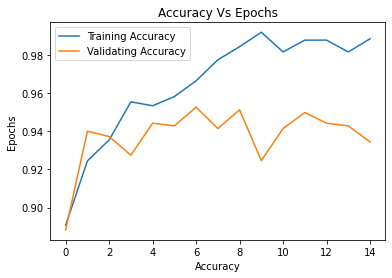

In [14]:
 plt.title("Accuracy Vs Epochs")
 plt.plot(range(epochs), train_accs, 
    label="Training Accuracy")
 plt.plot(range(epochs), valid_accs, 
    label="Validating Accuracy")
 plt.legend()
 plt.xlabel("Accuracy")
 plt.ylabel("Epochs")
 plt.show()

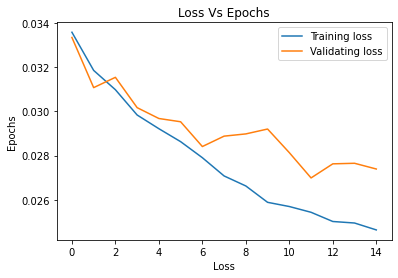

In [15]:
 plt.title("Loss Vs Epochs")
 plt.plot(range(epochs), train_losses, 
    label="Training loss")
 plt.plot(range(epochs), valid_losses, 
    label="Validating loss")
 plt.legend()
 plt.xlabel("Loss")
 plt.ylabel("Epochs")
 plt.show()

## Smoke detection model training

In [16]:
smoke_model = CNN_fire()
smoke_model.to(device)

CNN_fire(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10816, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(smoke_model.parameters(), lr=0.001)

epochs = 15

smoke_train_accs = []
smoke_train_losses = []

smoke_valid_accs = []
smoke_valid_losses = []
smoke_valid_labels = []
smoke_valid_preds =[]

for epoch in range(epochs):

    train_acc = 0
    train_loss = 0

    smoke_model.train()

    for images, labels in smoke_train_dataloader:
        optimizer.zero_grad()
        output = smoke_model(images)
        loss = loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(output, 1)

        train_acc += (predictions == labels).sum().item()
        train_loss += loss.item()

    smoke_train_accs.append(train_acc / len(smoke_train_data))
    smoke_train_losses.append(train_loss / len(smoke_train_data))

    smoke_model.eval()

    valid_acc = 0
    valid_loss = 0

    with torch.no_grad():
        for images, labels in smoke_valid_dataloader:
            output = smoke_model(images)
            loss = loss_fn(output, labels)

            predictions = torch.argmax(output, 1)

            valid_acc += (predictions == labels).sum().item()
            valid_loss += loss.item()
            
            smoke_valid_labels.extend(labels)
            smoke_valid_preds.extend(predictions)

    smoke_valid_accs.append(valid_acc / len(smoke_val_data))
    smoke_valid_losses.append(valid_loss / len(smoke_val_data))

    print(f"Epoch {epoch + 1}")
    print(f"Training Accuracy: {round(train_acc / len(smoke_train_data), 3)} \
    Training Loss: {round(train_loss / len(smoke_train_data), 3)}")
    print(f"Validation Accuracy: {round(valid_acc / len(smoke_val_data), 3)} \
    Validation Loss: {round(valid_loss / len(smoke_val_data), 3)}\n")



Epoch 1
Training Accuracy: 0.954     Training Loss: 0.033
Validation Accuracy: 0.986     Validation Loss: 0.031

Epoch 2
Training Accuracy: 0.983     Training Loss: 0.03
Validation Accuracy: 0.999     Validation Loss: 0.028

Epoch 3
Training Accuracy: 0.984     Training Loss: 0.028
Validation Accuracy: 1.0     Validation Loss: 0.026

Epoch 4
Training Accuracy: 0.989     Training Loss: 0.026
Validation Accuracy: 1.0     Validation Loss: 0.025

Epoch 5
Training Accuracy: 0.989     Training Loss: 0.025
Validation Accuracy: 0.997     Validation Loss: 0.025

Epoch 6
Training Accuracy: 0.995     Training Loss: 0.024
Validation Accuracy: 1.0     Validation Loss: 0.023

Epoch 7
Training Accuracy: 0.988     Training Loss: 0.024
Validation Accuracy: 0.997     Validation Loss: 0.023

Epoch 8
Training Accuracy: 0.982     Training Loss: 0.023
Validation Accuracy: 0.998     Validation Loss: 0.022

Epoch 9
Training Accuracy: 0.992     Training Loss: 0.022
Validation Accuracy: 0.992     Validation Los

## Metrics

In [18]:
print("Confusion matrix for smoke detection:")
print(confusion_matrix(smoke_valid_labels, smoke_valid_preds))

# Confusion matrix of shape
# True Positive     False Positive
# False Negative    True Negative

Confusion matrix for smoke detection:
[[ 6464    16]
 [   58 24977]]


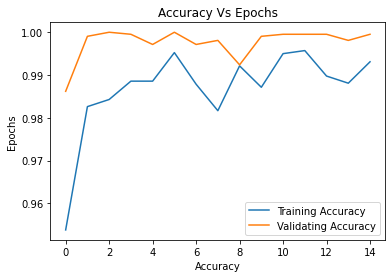

In [19]:
 plt.title("Accuracy Vs Epochs")
 plt.plot(range(epochs), smoke_train_accs, 
    label="Training Accuracy")
 plt.plot(range(epochs), smoke_valid_accs, 
    label="Validating Accuracy")
 plt.legend()
 plt.xlabel("Accuracy")
 plt.ylabel("Epochs")
 plt.show()

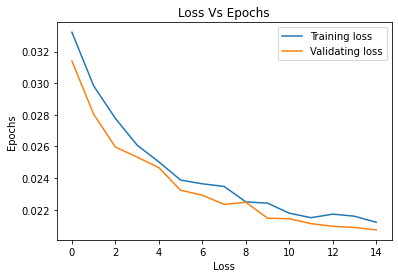

In [20]:
 plt.title("Loss Vs Epochs")
 plt.plot(range(epochs), smoke_train_losses, 
    label="Training loss")
 plt.plot(range(epochs), smoke_valid_losses, 
    label="Validating loss")
 plt.legend()
 plt.xlabel("Loss")
 plt.ylabel("Epochs")
 plt.show()

## Fire model evaluation

In [21]:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for X_batch, y_batch in valid_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

In [22]:
X, Y_true, Y_pred = X_batch.cpu(), y_batch.cpu(), y_pred.cpu()

In [23]:
Y_pred

tensor([[0.0905, 0.9090],
        [0.0941, 0.9037],
        [0.8135, 0.1903],
        [0.0824, 0.9163],
        [0.0936, 0.9094],
        [0.0878, 0.9149],
        [0.8350, 0.1620],
        [0.1030, 0.8973],
        [0.8368, 0.1660],
        [0.8533, 0.1416],
        [0.8687, 0.1301],
        [0.1013, 0.8968]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

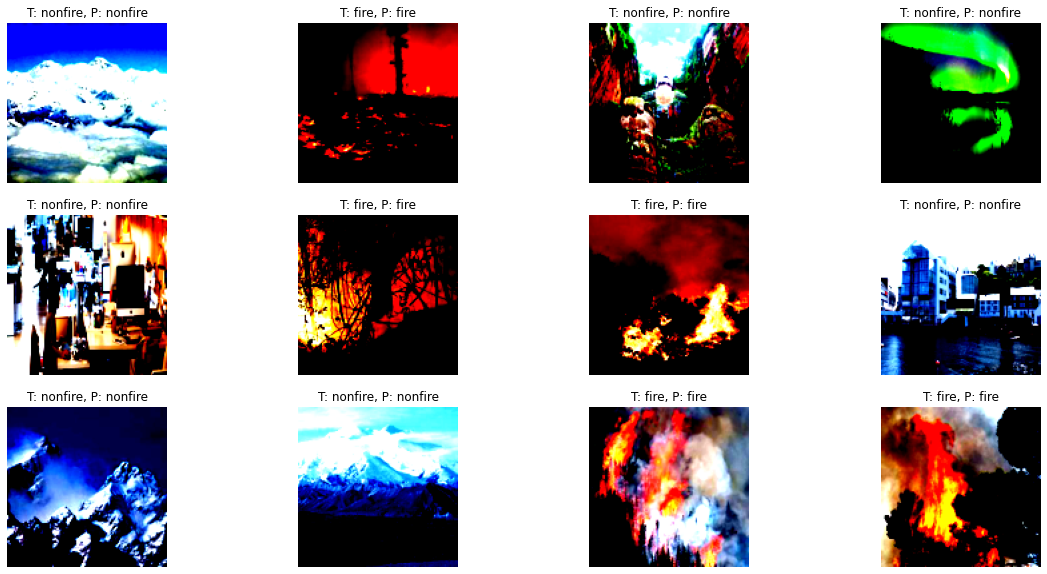

In [24]:
w, h = 4, 3
all_imgs, correct = 0, 0
rand_idxs = np.random.choice(np.arange(len(X)), replace=False, size=w*h)
fig, axes = plt.subplots(ncols=w, nrows=h, figsize=(20, 10))
for idx, ax in zip(rand_idxs, axes.ravel()):
    x, y_true, y_pred = X[idx], Y_true[idx], torch.round(Y_pred[idx][1]).int()
    if y_pred == y_true:
        correct += 1
    all_imgs += 1
    ax.imshow(x.permute(1, 2, 0))
    ax.title.set_text(f'T: {label2name[y_true]}, P: {label2name[y_pred]}')
    ax.axis('off')


In [25]:
print(f"Accuracy for fire detection: {correct/all_imgs}")
print("Confusion matrix for fire detection:")
print(confusion_matrix(Y_true, [torch.round(x[1]).int() for x in Y_pred]))

Accuracy for fire detection: 1.0
Confusion matrix for fire detection:
[[5 0]
 [0 7]]


## Smoke model evaluation

In [26]:
smoke_model.eval()
with torch.no_grad():
    for X_batch, y_batch in smoke_valid_dataloader:
        X_batch_smoke, y_batch_smoke = X_batch.to(device), y_batch.to(device)
        y_pred_smoke = smoke_model(X_batch_smoke)

In [27]:
X_smoke, Y_true_smoke, Y_pred_smoke = X_batch_smoke.cpu(), y_batch_smoke.cpu(), y_pred_smoke.cpu()

In [28]:
Y_pred_smoke

tensor([[0.0265, 0.9733],
        [0.0260, 0.9740],
        [0.0262, 0.9747],
        [0.0288, 0.9717],
        [0.0267, 0.9733]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


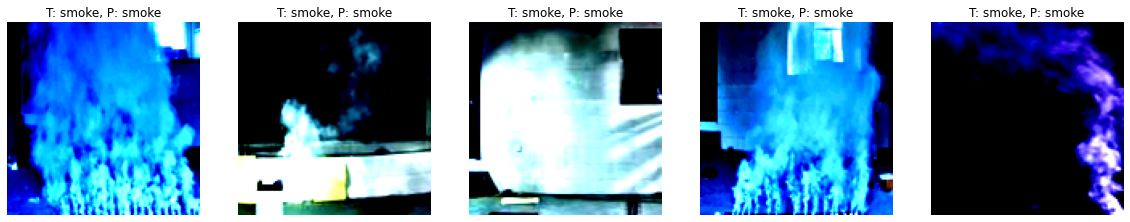

In [29]:
w, h = 5, 1
all_imgs, correct = 0, 0
rand_idxs = np.random.choice(np.arange(len(X_smoke)), replace=False, size=w*h)
fig, axes = plt.subplots(ncols=w, nrows=h, figsize=(20, 10))
for idx, ax in zip(rand_idxs, axes.ravel()):
    x, y_true, y_pred = X_smoke[idx], Y_true_smoke[idx], torch.round(Y_pred_smoke[idx][1]).int()
    if y_pred == y_true:
        correct += 1
    all_imgs += 1
    ax.imshow(x.permute(1, 2, 0))
    ax.title.set_text(f'T: {smoke_label2name[y_true]}, P: {smoke_label2name[y_pred]}')
    ax.axis('off')


In [30]:
print(f"Accuracy for smoke detection: {correct/all_imgs}")
print("Confusion matrix for smoke detection:")
print(confusion_matrix(Y_true_smoke, [torch.round(x[1]).int() for x in Y_pred_smoke]))

Accuracy for smoke detection: 1.0
Confusion matrix for smoke detection:
[[5]]


## Fire and smoke images labeling

In [31]:
fire_and_smoke_data = datasets.ImageFolder('data/dataset-merged/testing',       
                    transform=train_transform)

In [32]:
testing_dataloader = torch.utils.data.DataLoader(
    fire_and_smoke_data, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=3
)

In [33]:
model.eval()
smoke_model.eval()

with torch.no_grad():
    for X_batch, y_batch in testing_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_fire = model(X_batch)
        y_pred_smoke = smoke_model(X_batch)

X_1, Y_pred_fire_1, Y_pred_smoke_1 = X_batch.cpu(), y_pred_fire.cpu(), y_pred_smoke.cpu()

with torch.no_grad():
    for X_batch, y_batch in valid_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_fire = model(X_batch)
        y_pred_smoke = smoke_model(X_batch)

X_2, Y_pred_fire_2, Y_pred_smoke_2 = X_batch.cpu(), y_pred_fire.cpu(), y_pred_smoke.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

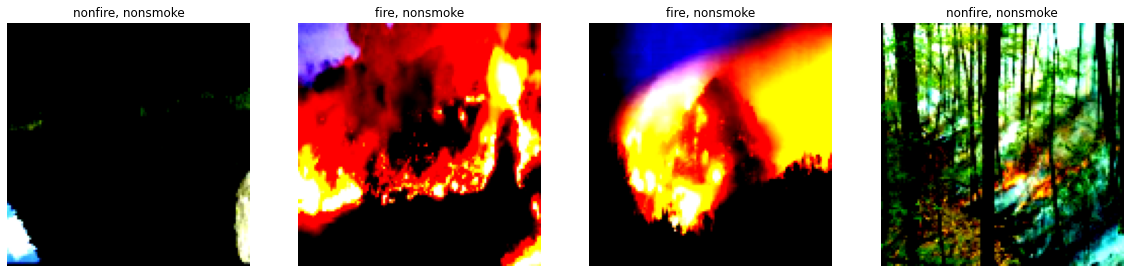

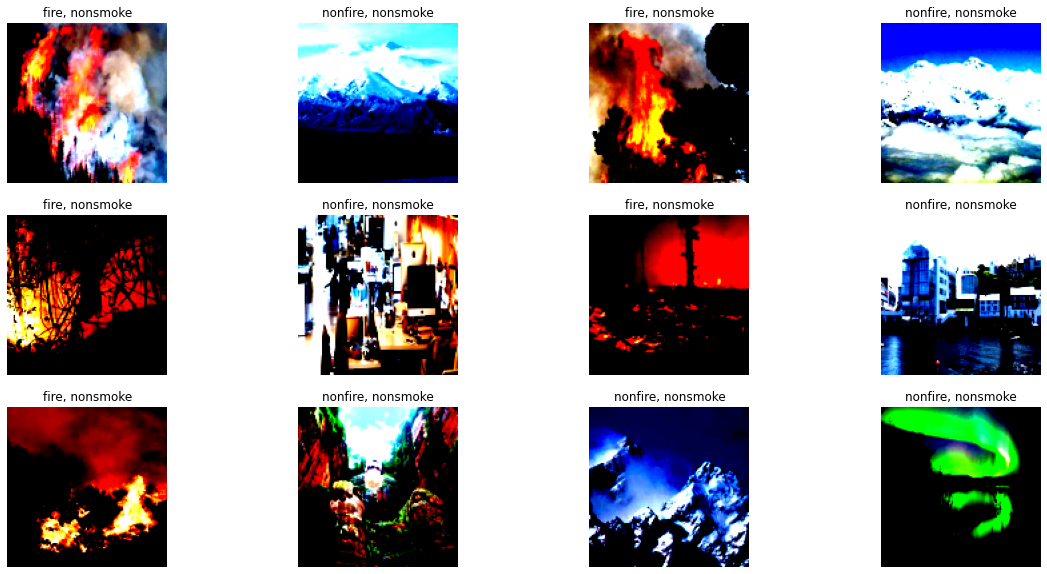

In [34]:
w, h = 4, 1
rand_idxs = np.random.choice(np.arange(len(X_1)), replace=False, size=w*h)
fig, axes = plt.subplots(ncols=w, nrows=h, figsize=(20, 10))
for idx, ax in zip(rand_idxs, axes.ravel()):
    x, y_pred_fire, y_pred_smoke = X_1[idx], torch.round(Y_pred_fire_1[idx][1]).int(), torch.round(Y_pred_smoke_1[idx][1]).int()
    ax.imshow(x.permute(1, 2, 0))
    ax.title.set_text(f'{label2name[y_pred_fire]}, {smoke_label2name[y_pred_smoke]}')
    ax.axis('off')

w, h = 4, 3
rand_idxs = np.random.choice(np.arange(len(X_2)), replace=False, size=w*h)
fig, axes = plt.subplots(ncols=w, nrows=h, figsize=(20, 10))
for idx, ax in zip(rand_idxs, axes.ravel()):
    x, y_pred_fire, y_pred_smoke = X_2[idx], torch.round(Y_pred_fire_2[idx][1]).int(), torch.round(Y_pred_smoke_2[idx][1]).int()
    ax.imshow(x.permute(1, 2, 0))
    ax.title.set_text(f'{label2name[y_pred_fire]}, {smoke_label2name[y_pred_smoke]}')
    ax.axis('off')


# Superpixel image segmentation

In [35]:
# !pip uninstall opencv-contrib-python opencv-python -y

In [36]:
# !pip install opencv-contrib-python --upgrade

In [37]:
import cv2
import glob
from PIL import Image
from tqdm import tqdm

In [38]:
def display_image(image, size=(8, 8)):
    """Display image using matplotlib"""
    plt.figure(figsize=size)
    plt.imshow(image)
    plt.axis("off")

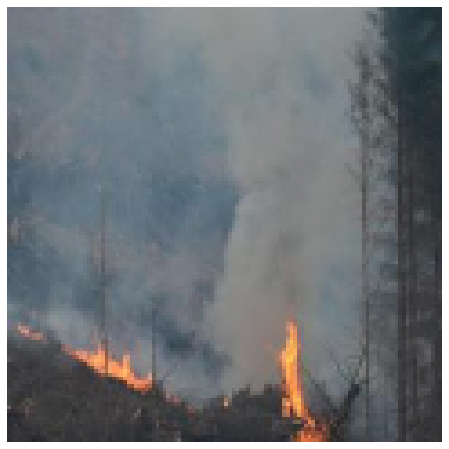

In [55]:
# read 12 images for the test (you can take any of them)
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob("data/for_segmentation/fire/*.jpg")]
images = [cv2.resize(img, (120, 120)) for img in images]
img = images[0]
display_image(img)

In [56]:
slic = cv2.ximgproc.createSuperpixelSLIC(img, region_size=15)
slic.iterate(10)

In [57]:
segments = slic.getLabels()

In [58]:
model.eval()
smoke_model.eval()
for (i, segVal) in tqdm(enumerate(np.unique(segments))):
        mask = np.zeros(img.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255

        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        superpixel = cv2.bitwise_and(img, img, mask = mask)
        
        # from superpixel ndarray create image
        superpixel = Image.fromarray(superpixel, 'RGB')
        
#         display_image(train_transform(superpixel).permute(1, 2, 0))
        
        # add to the DataLoader
        superpixel = torch.utils.data.DataLoader(
            [train_transform(superpixel)], batch_size=1,
            shuffle=False, num_workers=3
        )
        
        # feed image superpixel to a model
        with torch.no_grad():
            for X_batch in superpixel:
                X_batch = X_batch.to(device)
                y_pred_fire = model(X_batch)
                y_pred_smoke = smoke_model(X_batch)
        y_pred_fire, y_pred_smoke = y_pred_fire.cpu(), y_pred_smoke.cpu()
        output_fire, output_smoke = y_pred_fire[0][0], y_pred_smoke[0][0]
#         print(output_fire, output_smoke)

        # you can try to change confirmation levels
        if output_fire >= 0.85 and output_smoke >= 0.85:
            cv2.drawContours(img, contours, -1, (0, 255, 0), 1)
        elif output_fire >= 0.85:
            cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
        elif output_smoke >= 0.85:
            cv2.drawContours(img, contours, -1, (0, 0, 255), 1)

64it [01:28,  1.39s/it]


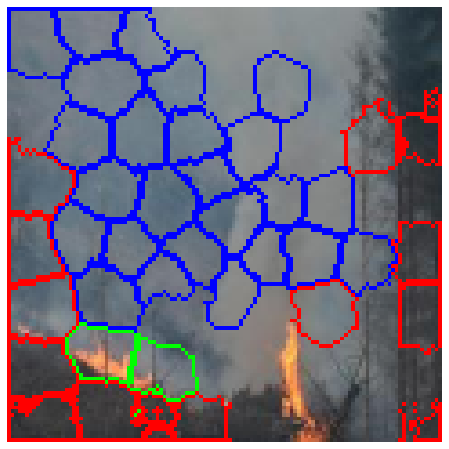

In [59]:
display_image(img)

In [44]:
# Image.fromarray(img, 'RGB').save("data/segmentation_results/photo.jpg")